In [ ]:
from google.colab import drive  # Import the 'drive' object

drive.mount('/content/drive')  # Mount Google Drive to '/content/drive'

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# -*- coding: utf-8 -*-
"""Adobe_DevCraft.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1H6Q_rXGtNmsPL29NFUc34sEU2Uth6qTc
"""

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler  # Added for feature normalization

# Define file paths
data_dir = "/content/drive/MyDrive/bids.csv"

# Advertiser-specific N values
advertiser_N = {1458: 0, 3358: 2, 3386: 0, 3427: 0, 3476: 10}

df = pd.read_csv(data_dir)

# Drop rows with missing BidID
df.dropna(subset=['BidID'], inplace=True)

df.dropna(subset=['Payingprice_y'], inplace=True)

<ipython-input-84-6db656249398>:23: DtypeWarning: Columns (10,11,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_dir)


In [ ]:
df['Clicks'].unique()

array([0, 1, 2, 3, 5, 4, 7, 9])

In [ ]:
df['Conversions'].unique()

array([0, 1, 2, 3])

In [ ]:
df['Impressions'].unique()

array([ 1,  2,  3,  4,  7,  5,  6, 15, 14,  9, 12])

In [ ]:
df.columns

Index(['BidID', 'Timestamp', 'VisitorID', 'User-Agent', 'IP', 'Region', 'City',
       'Adexchange', 'Domain', 'URL', 'AnonymousURLID', 'AdslotID',
       'Adslotwidth', 'Adslotheight', 'Adslotvisibility', 'Adslotformat',
       'Adslotfloorprice', 'CreativeID', 'Biddingprice', 'AdvertiserID',
       'Logtype', 'Payingprice_x', 'KeypageURL_x', 'Payingprice_y',
       'KeypageURL_y', 'Targetting_Categories', 'Impressions', 'Clicks',
       'Conversions'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1815075 entries, 1 to 9586948
Data columns (total 29 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   BidID                  object 
 1   Timestamp              int64  
 2   VisitorID              object 
 3   User-Agent             object 
 4   IP                     object 
 5   Region                 int64  
 6   City                   int64  
 7   Adexchange             int64  
 8   Domain                 object 
 9   URL                    object 
 10  AnonymousURLID         object 
 11  AdslotID               object 
 12  Adslotwidth            int64  
 13  Adslotheight           int64  
 14  Adslotvisibility       int64  
 15  Adslotformat           int64  
 16  Adslotfloorprice       int64  
 17  CreativeID             object 
 18  Biddingprice           int64  
 19  AdvertiserID           int64  
 20  Logtype                float64
 21  Payingprice_x          float64
 22  KeypageURL_x           

In [ ]:
# Extract time-based features
df['Hour'] = pd.to_datetime(df['Timestamp'], format='%Y%m%d%H%M%S%f', errors='coerce').dt.hour
df['Weekday'] = pd.to_datetime(df['Timestamp'], format='%Y%m%d%H%M%S%f', errors='coerce').dt.weekday
df.drop(columns=['Timestamp'], inplace=True)


In [ ]:

# Process User-Agent (Extract OS & Browser)
df['Browser'] = df['User-Agent'].str.extract(r'(Chrome|Firefox|Safari|Edge|Opera|IE)', expand=False).fillna('Other')
df['OS'] = df['User-Agent'].str.extract(r'(Windows|Mac|Linux|Android|iOS)', expand=False).fillna('Other')
df.drop(columns=['User-Agent'], inplace=True)

In [ ]:

# ✅ Fill missing Biddingprice before computing WinRate
df['Biddingprice'].fillna(df['Biddingprice'].median(), inplace=True)

# Compute Market Price Estimate (Rolling Median)
df['MarketPriceEstimate'] = df.groupby(['AdvertiserID'])['Payingprice_y'].transform(lambda x: x.rolling(10, min_periods=1).median())
df['MarketPriceEstimate'].fillna(df['Payingprice_y'].median(), inplace=True)

<ipython-input-92-ba0828a7cf95>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Biddingprice'].fillna(df['Biddingprice'].median(), inplace=True)
<ipython-input-92-ba0828a7cf95>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

In [ ]:
df['HistoricalCTR'] = df.groupby(['AdvertiserID'])['Clicks'].transform(lambda x: x.rolling(10, min_periods=1).sum()) / df.groupby(['AdvertiserID'])['Impressions'].transform(lambda x: x.rolling(10, min_periods=1).sum())
df['HistoricalCTR'].fillna(0, inplace=True)

df['HistoricalCVR'] = df.groupby(['AdvertiserID'])['Conversions'].transform(lambda x: x.rolling(10, min_periods=1).sum()) / df.groupby(['AdvertiserID'])['Clicks'].transform(lambda x: x.rolling(10, min_periods=1).sum())
df['HistoricalCVR'].fillna(0, inplace=True)

df['WinRate'] = df['Impressions'] / (df['Impressions'] + df['Biddingprice'])
df['WinRate'].fillna(0, inplace=True)

<ipython-input-93-177a1f244819>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['HistoricalCTR'].fillna(0, inplace=True)
<ipython-input-93-177a1f244819>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df

In [ ]:
df.columns

Index(['BidID', 'VisitorID', 'IP', 'Region', 'City', 'Adexchange', 'Domain',
       'URL', 'AnonymousURLID', 'AdslotID', 'Adslotwidth', 'Adslotheight',
       'Adslotvisibility', 'Adslotformat', 'Adslotfloorprice', 'CreativeID',
       'Biddingprice', 'AdvertiserID', 'Logtype', 'Payingprice_x',
       'KeypageURL_x', 'Payingprice_y', 'KeypageURL_y',
       'Targetting_Categories', 'Impressions', 'Clicks', 'Conversions', 'Hour',
       'Weekday', 'Browser', 'OS', 'MarketPriceEstimate', 'HistoricalCTR',
       'HistoricalCVR', 'WinRate'],
      dtype='object')

In [ ]:
df['BidID'] = df['BidID'].astype(str)

# 1️⃣ Drop unnecessary columns
drop_cols = ['VisitorID', 'IP', 'Domain', 'URL', 'AnonymousURLID', 'AdslotID', 'CreativeID', 'KeypageURL_y', 'Targetting_Categories', 'Payingprice_x', 'Logtype', 'KeypageURL_x']
df.drop(columns=drop_cols, inplace=True, axis=1)

# 2️⃣ Define numeric columns
numeric_cols = ['Biddingprice', 'Payingprice_y', 'Adslotfloorprice', 'Hour', 'Weekday',
                'Adslotwidth', 'Adslotheight',
                'MarketPriceEstimate', 'HistoricalCTR', 'HistoricalCVR', 'WinRate']
# 'Impressions', 'Clicks', 'Conversions',
# 3️⃣ One-Hot Encode Categorical Columns
categorical_cols = ['Adexchange', 'Adslotvisibility', 'Adslotformat', 'Browser', 'OS']
df = pd.get_dummies(df, columns=categorical_cols)


In [ ]:
# # Ensure all missing values are filled before normalization
# df.fillna(0, inplace=True)


# # 4️⃣ Normalize numeric features
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [ ]:

# ✅ Convert counts to integer type
df[["Impressions", "Clicks", "Conversions"]] = df[["Impressions", "Clicks", "Conversions"]].astype(int)

# ✅ Convert one-hot encoded `bool` columns to `int`
bool_cols = df.select_dtypes(include=['bool']).columns  # Get all boolean columns
df[bool_cols] = df[bool_cols].astype(int)

# Debugging: Print processed features
print("Processed Bids Data:")
print(df.head(5))


Processed Bids Data:
                               BidID  Region  City  Adslotwidth  Adslotheight  \
1    7b6195de0d14203f92001da653bf1de     216   217          468            60   
3   8a15b98c8f9e60d4f92aaab01acf52a4     106   117          950            90   
4   faf17eac9cabf1be598f4e75f40d501d      94    95          950            90   
8   a70cf453f7b670cd8de0b85446ab1bd6      80    85          300           250   
10  b009310883916b99fe707e7a0798bd01     253   254          300           250   

    Adslotfloorprice  Biddingprice  AdvertiserID  Payingprice_y  Impressions  \
1                  5           300          3386           18.0            1   
3                  0           227          3427          207.0            1   
4                  0           227          3358          108.0            1   
8                  0           227          3427          181.0            1   
10                 0           227          3427          181.0            1   

    ...  Br

In [ ]:
print("Columns and Data Types:")
print(df.dtypes)
df.describe()

Columns and Data Types:
BidID                    object
Region                    int64
City                      int64
Adslotwidth               int64
Adslotheight              int64
Adslotfloorprice          int64
Biddingprice              int64
AdvertiserID              int64
Payingprice_y           float64
Impressions               int64
Clicks                    int64
Conversions               int64
Hour                      int32
Weekday                   int32
MarketPriceEstimate     float64
HistoricalCTR           float64
HistoricalCVR           float64
WinRate                 float64
Adexchange_1              int64
Adexchange_2              int64
Adexchange_3              int64
Adslotvisibility_0        int64
Adslotvisibility_1        int64
Adslotvisibility_2        int64
Adslotvisibility_255      int64
Adslotformat_0            int64
Adslotformat_1            int64
Adslotformat_5            int64
Browser_Chrome            int64
Browser_Firefox           int64
Browser_IE      

,Region,City,Adslotwidth,Adslotheight,Adslotfloorprice,Biddingprice,AdvertiserID,Payingprice_y,Impressions,Clicks,...,Browser_IE,Browser_Opera,Browser_Other,Browser_Safari,OS_Android,OS_Linux,OS_Mac,OS_Other,OS_Windows,OS_iOS
count,1.815075e+06,1.815075e+06,1.815075e+06,1.815075e+06,1.815075e+06,1.815075e+06,1.815075e+06,1.815075e+06,1.815075e+06,1.815075e+06,...,1.815075e+06,1.815075e+06,1.815075e+06,1.815075e+06,1.815075e+06,1.815075e+06,1.815075e+06,1.815075e+06,1.815075e+06,1.815075e+06
mean,1.485094e+02,1.532822e+02,5.491712e+02,1.984913e+02,2.313188e+01,2.691721e+02,2.934356e+03,7.476850e+01,1.003459e+00,7.046541e-04,...,4.458086e-01,9.156646e-04,2.956671e-01,8.058069e-03,1.652824e-05,7.724199e-04,8.659697e-03,2.918866e-01,6.986637e-01,1.101883e-06
std,1.053062e+02,1.065646e+02,3.091070e+02,1.291238e+02,3.226345e+01,3.057464e+01,8.450531e+02,6.063593e+01,6.427378e-02,3.069470e-02,...,4.970548e-01,3.024610e-02,4.563422e-01,8.940437e-02,4.065462e-03,2.778171e-02,9.265372e-02,4.546305e-01,4.588386e-01,1.049706e-03
min,-1.000000e+00,-1.000000e+00,1.200000e+02,6.000000e+01,0.000000e+00,2.270000e+02,1.458000e+03,0.000000e+00,1.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.500000e+01,7.700000e+01,3.000000e+02,9.000000e+01,0.000000e+00,2.380000e+02,3.358000e+03,2.800000e+01,1.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.460000e+02,1.480000e+02,3.360000e+02,2.500000e+02,5.000000e+00,2.540000e+02,3.386000e+03,5.800000e+01,1.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
75%,2.160000e+02,2.220000e+02,9.500000e+02,2.500000e+02,5.000000e+01,3.000000e+02,3.427000e+03,9.500000e+01,1.000000e+00,0.000000e+00,...,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
max,3.950000e+02,3.990000e+02,1.000000e+03,6.000000e+02,2.980000e+02,3.000000e+02,3.476000e+03,3.000000e+02,1.500000e+01,9.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [ ]:
df['HistoricalCVR'].unique()

array([0., 1.])

In [ ]:
class BidRequest:
    serialVersionUID = -3012027079030559912

    def __init__(self, adslot_id=None, adexchange=None, advertiser_id=None, region=None, floor_price=None):
        self.bidId = None
        self.timestamp = None
        self.visitorId = None
        self.userAgent = None
        self.ipAddress = None
        self.region = region
        self.city = None
        self.Adexchange = adexchange
        self.domain = None
        self.url = None
        self.anonymousURLID = None
        self.AdslotID = adslot_id
        self.adSlotWidth = None
        self.adSlotHeight = None
        self.adSlotVisibility = None
        self.adSlotFormat = None
        self.adSlotFloorPrice = floor_price
        self.creativeID = None
        self.advertiserId = advertiser_id
        self.userTags = None

    def getBidId(self) -> str:
        return self.bidId

    def setBidId(self, bidId: str):
        self.bidId = bidId

    def getTimestamp(self) -> str:
        return self.timestamp

    def setTimestamp(self, timestamp: str):
        self.timestamp = timestamp

    def getVisitorId(self) -> str:
        return self.visitorId

    def setVisitorId(self, visitorId: str):
        self.visitorId = visitorId

    def getUserAgent(self) -> str:
        return self.userAgent

    def setUserAgent(self, userAgent: str):
        self.userAgent = userAgent

    def getIpAddress(self) -> str:
        return self.ipAddress

    def setIpAddress(self, ipAddress: str):
        self.ipAddress = ipAddress

    def getRegion(self) -> str:
        return self.region

    def setRegion(self, region: str):
        self.region = region

    def getCity(self) -> str:
        return self.city

    def setCity(self, city: str):
        self.city = city

    def getAdExchange(self) -> str:
        return self.Adexchange

    def setAdExchange(self, adExchange: str):
        self.Adexchange = adExchange

    def getDomain(self) -> str:
        return self.domain

    def setDomain(self, domain: str):
        self.domain = domain

    def getUrl(self) -> str:
        return self.url

    def setUrl(self, url: str):
        self.url = url

    def getAnonymousURLID(self) -> str:
        return self.anonymousURLID

    def setAnonymousURLID(self, anonymousURLID: str):
        self.anonymousURLID = anonymousURLID

    def getAdSlotID(self) -> str:
        return self.AdslotID

    def setAdSlotID(self, AdslotID: str):
        self.AdslotID = AdslotID

    def getAdSlotWidth(self) -> str:
        return self.adSlotWidth

    def setAdSlotWidth(self, adSlotWidth: str):
        self.adSlotWidth = adSlotWidth

    def getAdSlotHeight(self) -> str:
        return self.adSlotHeight

    def setAdSlotHeight(self, adSlotHeight: str):
        self.adSlotHeight = adSlotHeight

    def getAdSlotVisibility(self) -> str:
        return self.adSlotVisibility

    def setAdSlotVisibility(self, adSlotVisibility: str):
        self.adSlotVisibility = adSlotVisibility

    def getAdSlotFormat(self) -> str:
        return self.adSlotFormat

    def setAdSlotFormat(self, adSlotFormat: str):
        self.adSlotFormat = adSlotFormat

    def getAdSlotFloorPrice(self) -> str:
        return self.adSlotFloorPrice

    def setAdSlotFloorPrice(self, adSlotFloorPrice: str):
        self.adSlotFloorPrice = adSlotFloorPrice

    def getCreativeID(self) -> str:
        return self.creativeID

    def setCreativeID(self, creativeID: str):
        self.creativeID = creativeID

    def getAdvertiserId(self) -> str:
        return self.advertiserId

    def setAdvertiserId(self, advertiserId: str):
        self.advertiserId = advertiserId

    def getUserTags(self) -> str:
        return self.userTags

    def setUserTags(self, userTags: str):
        self.userTags = userTags

In [ ]:
#from BidRequest import BidRequest

class Bidder():

    def getBidPrice(self, bidRequest: BidRequest) -> int:
        pass

In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 MB 5.2 MB/s eta 0:00:00


In [ ]:
df['Impressions'].unique()

array([ 1,  2,  3,  4,  7,  5,  6, 15, 14,  9, 12])

In [ ]:
df['Conversions'].unique()

array([0, 1, 2, 3])

In [ ]:
df['Clicks'].unique()

array([0, 1, 2, 3, 5, 4, 7, 9])

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Calculate CTR (Click-through Rate) and CVR (Conversion Rate)
# CTR = Clicks / Impressions
# CVR = Conversions / Clicks
df["CTR"] = df["Clicks"] / df["Impressions"]
df["CVR"] = df["Conversions"] / df["Clicks"]
df["CVR"].fillna(0, inplace=True)  # Fill NaN when Clicks = 0

# Interaction terms
df['AdslotBiddingInteraction'] = df['Adslotwidth'] * df['Biddingprice']
df['AdslotFloorPriceBidding'] = df['Adslotfloorprice'] * df['Biddingprice']

# Historical features (rolling averages for CTR and CVR)
df['RollingCTR'] = df['CTR'].rolling(window=5).mean()
df['RollingCVR'] = df['CVR'].rolling(window=5).mean()
df['RollingClicks'] = df['Clicks'].rolling(window=5).mean()
df['RollingImpressions'] = df['Impressions'].rolling(window=5).mean()

# Fill missing rolling features
df.fillna(0, inplace=True)

<ipython-input-105-8deeafe6773d>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["CVR"].fillna(0, inplace=True)  # Fill NaN when Clicks = 0


In [ ]:
# Log transformation for skewed features
#df['LogBiddingprice'] = np.log1p(df['Biddingprice'])  # Log(1+x) transformation to handle 0 values
df['LogImpressions'] = np.log1p(df['Impressions'])


# Update features list to include transformed features
features = [
    "Adslotwidth", "Adslotheight",  "Adslotfloorprice",
    "MarketPriceEstimate", "AdvertiserID", "Adexchange_1",
    "Adexchange_2", "Adexchange_3",  "RollingCTR", "RollingCVR"
]

# # Normalize Numerical Features
# scaler = StandardScaler()
# df[["Adslotfloorprice", "LogBiddingprice", "Adslotwidth", "Adslotheight",
#     "MarketPriceEstimate", "RollingCTR", "RollingCVR", "RollingClicks"]] = scaler.fit_transform(
#     df[["Adslotfloorprice", "LogBiddingprice", "Adslotwidth", "Adslotheight",
#          "MarketPriceEstimate", "RollingCTR", "RollingCVR", "RollingClicks"]])

# Define Target Variables (CTR & CVR as Continuous)
X = df[features]
y_ctr = df["CTR"]
y_cvr = df["CVR"]

In [ ]:
# Train-Test Split
X_train_ctr, X_test_ctr, y_train_ctr, y_test_ctr = train_test_split(X, y_ctr, test_size=0.2, random_state=42)
X_train_cvr, X_test_cvr, y_train_cvr, y_test_cvr = train_test_split(X, y_cvr, test_size=0.2, random_state=42)

# XGBoost Hyperparameter Grid
param_grid = {
    'max_depth': [3, 6, 9, 12, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Tune CTR Model using Randomized Search
ctr_xgb = xgb.XGBRegressor(objective="reg:squarederror", eval_metric="rmse", random_state=42)
ctr_search = RandomizedSearchCV(ctr_xgb, param_grid, n_iter=10, scoring="neg_root_mean_squared_error", cv=3, verbose=1, n_jobs=-1)
ctr_search.fit(X_train_ctr, y_train_ctr)

# Get Best CTR Model Parameters
best_ctr_params = ctr_search.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
# Train Final CTR Model
ctr_model = xgb.XGBRegressor(**best_ctr_params, objective="reg:squarederror", eval_metric="rmse", random_state=42)
ctr_model.fit(X_train_ctr, y_train_ctr, eval_set=[(X_test_ctr, y_test_ctr)], verbose=False)

# Tune CVR Model using Randomized Search
cvr_xgb = xgb.XGBRegressor(objective="reg:squarederror", eval_metric="rmse", random_state=42)
cvr_search = RandomizedSearchCV(cvr_xgb, param_grid, n_iter=10, scoring="neg_root_mean_squared_error", cv=3, verbose=1, n_jobs=-1)
cvr_search.fit(X_train_cvr, y_train_cvr)

# Get Best CVR Model Parameters
best_cvr_params = cvr_search.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:

# Train Final CVR Model
cvr_model = xgb.XGBRegressor(**best_cvr_params, objective="reg:squarederror", eval_metric="rmse", random_state=42)
cvr_model.fit(X_train_cvr, y_train_cvr, eval_set=[(X_test_cvr, y_test_cvr)], verbose=False)

# Evaluate Metrics
y_pred_ctr = ctr_model.predict(X_test_ctr)
y_pred_cvr = cvr_model.predict(X_test_cvr)

In [ ]:


# Compute RMSE
ctr_mse = mean_squared_error(y_test_ctr, y_pred_ctr)  # MSE
cvr_mse = mean_squared_error(y_test_cvr, y_pred_cvr)  # MSE

ctr_rmse = np.sqrt(ctr_mse)  # RMSE
cvr_rmse = np.sqrt(cvr_mse)  # RMSE

# Compute R² Score
ctr_r2 = r2_score(y_test_ctr, y_pred_ctr)
cvr_r2 = r2_score(y_test_cvr, y_pred_cvr)

# Display Results
print(f"🔥 CTR Model RMSE: {ctr_rmse:.4f} | CTR Model R² Score: {ctr_r2:.4f}")
print(f"🔥 CVR Model RMSE: {cvr_rmse:.4f} | CVR Model R² Score: {cvr_r2:.4f}")

# Save Models
joblib.dump(ctr_model, "ctr_model.pkl")
joblib.dump(cvr_model, "cvr_model.pkl")


🔥 CTR Model RMSE: 0.0277 | CTR Model R² Score: -0.0349
🔥 CVR Model RMSE: 0.0043 | CVR Model R² Score: 0.1553


['cvr_model.pkl']

<Figure size 1000x600 with 0 Axes>

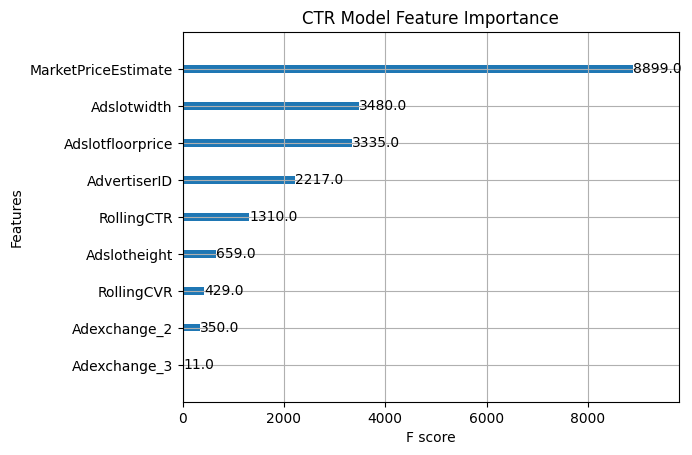

<Figure size 1000x600 with 0 Axes>

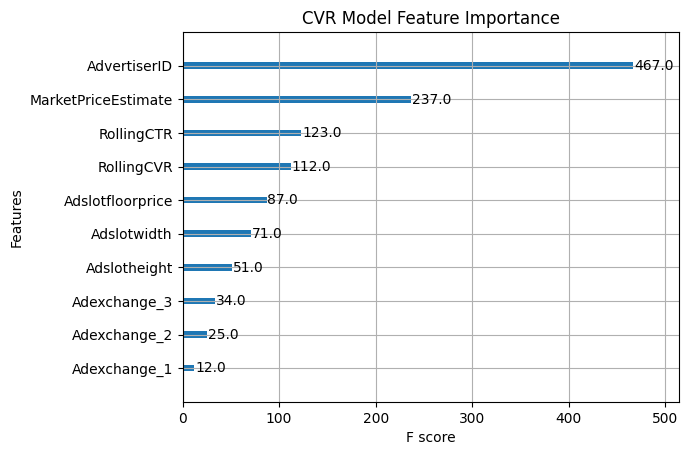

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

# ✅ Get feature importance for the CTR model
ctr_model_booster = ctr_model.get_booster()
ctr_importance = ctr_model_booster.get_score(importance_type='weight')  # You can also try 'gain' or 'cover'
ctr_importance_sorted = sorted(ctr_importance.items(), key=lambda x: x[1], reverse=True)

# ✅ Plot CTR feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(ctr_model, importance_type='weight', max_num_features=10)
plt.title("CTR Model Feature Importance")
plt.show()

# ✅ Get feature importance for the CVR model
cvr_model_booster = cvr_model.get_booster()
cvr_importance = cvr_model_booster.get_score(importance_type='weight')  # You can also try 'gain' or 'cover'
cvr_importance_sorted = sorted(cvr_importance.items(), key=lambda x: x[1], reverse=True)

# ✅ Plot CVR feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(cvr_model, importance_type='weight', max_num_features=10)
plt.title("CVR Model Feature Importance")
plt.show()


In [ ]:
# print(f"Columns in data: {list(data.columns)}")
# if "Payingprice" not in data.columns:
#     print("🚨 Payingprice column is missing!")
# else:
#     print(f"✅ Payingprice exists. Non-zero values count: {sum(data['Payingprice'] > 0)}")


Columns in data: ['BidID', 'Timestamp', 'VisitorID', 'User-Agent', 'IP', 'Region', 'City', 'Adexchange', 'Domain', 'URL', 'AnonymousURLID', 'AdslotID', 'Adslotwidth', 'Adslotheight', 'Adslotvisibility', 'Adslotformat', 'Adslotfloorprice', 'CreativeID', 'Biddingprice', 'AdvertiserID', 'Logtype', 'Payingprice', 'KeypageURL', 'Impression', 'Click', 'Conversion', 'Hour', 'DayOfWeek', 'PastImpressions', 'PastClicks', 'PastConversions', 'AdSlotAspectRatio', 'RegionCityCTR', 'Browser', 'OS', 'CTR', 'CVR', 'MedianMarketPrice', 'click', 'conversion', 'pCTR', 'pCVR', 'N', 'expected_value', 'optimized_bid']
✅ Payingprice exists. Non-zero values count: 0


In [ ]:
# import pandas as pd
# import numpy as np
# import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
# import joblib

# # Feature Engineering

#df['AdslotBiddingInteraction'] = df['Adslotwidth'] * df['Biddingprice']
# df['AdslotFloorPriceBidding'] = df['Adslotfloorprice'] * df['Biddingprice']
# df['RollingCTR'] = df['CTR'].rolling(window=5).mean()
# df['RollingCVR'] = df['CVR'].rolling(window=5).mean()
# df.fillna(0, inplace=True)

# # Log transformations for skewed variables
# df['LogBiddingprice'] = np.log1p(df['Biddingprice'])
# df['LogImpressions'] = np.log1p(df['Impressions'])

# Features and Labels (Focus on predicting Bidding Price)
features = [
    "Adslotwidth", "Adslotheight", "Adslotfloorprice",
    "MarketPriceEstimate",  "AdvertiserID", "Adexchange_1",
    "Adexchange_2", "Adexchange_3",  "RollingCTR", "RollingCVR"
]

# Train-test split
X = df[features]
y = df["Biddingprice"]  # Target is now Bidding Price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter Search for XGBoost
param_grid = {
    'max_depth': [3, 6, 9, 12],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Randomized Search
bid_xgb = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
bid_search = RandomizedSearchCV(bid_xgb, param_grid, n_iter=10, scoring="neg_mean_absolute_error", cv=3, n_jobs=-1)
bid_search.fit(X_train, y_train)

# Get Best Model
best_bid_params = bid_search.best_params_
bid_model = xgb.XGBRegressor(**best_bid_params, objective="reg:squarederror", random_state=42)
bid_model.fit(X_train, y_train)

# Predictions
y_pred = bid_model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"🔥 Bidding Price Model Performance:")
print(f"📌 MAE: {mae:.4f}")
print(f"📌 RMSE: {rmse:.4f}")

# Save the model for future use
joblib.dump(bid_model, "bid_price_model.pkl")


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


🔥 Bidding Price Model Performance:
📌 MAE: 0.0002
📌 RMSE: 0.0002


['bid_price_model.pkl']

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Load models
ctr_model = joblib.load("ctr_model.pkl")
cvr_model = joblib.load("cvr_model.pkl")
bid_model = joblib.load("bid_price_model.pkl")

# Example dataset for prediction (ad slots, features)
# You need to provide the ad slot data in the same format as during training.
# Example feature columns for a given impression
new_data =     {
        "Adslotwidth": [950],
        "Adslotheight": [90],

        "Adslotfloorprice": [0],
        "MarketPriceEstimate": [15],
        "AdvertiserID": [2345],
        "Adexchange_1": [1],
        "Adexchange_2": [0],
        "Adexchange_3": [0],
        "RollingCTR": [0.02],
        "RollingCVR": [0.05],

    }
dataset = [
    {
        "Adslotwidth": [950],
        "Adslotheight": [90],
        "LogBiddingprice": [np.log1p(753)],
        "Adslotfloorprice": [0],
        "MarketPriceEstimate": [15],
        "AdvertiserID": [2345],
        "Adexchange_1": [1],
        "Adexchange_2": [0],
        "Adexchange_3": [0],
        "RollingCTR": [0.02],
        "RollingCVR": [0.05],
        "AdslotBiddingInteraction": [950 * 753]
    },
    {
        "Adslotwidth": [950],
        "Adslotheight": [90],
        "LogBiddingprice": [np.log1p(753)],
        "Adslotfloorprice": [0],
        "MarketPriceEstimate": [15],
        "AdvertiserID": [2345],
        "Adexchange_1": [1],
        "Adexchange_2": [0],
        "Adexchange_3": [0],
        "RollingCTR": [0.02],
        "RollingCVR": [0.05],
        "AdslotBiddingInteraction": [950 * 753]
    },
    {
        "Adslotwidth": [728],
        "Adslotheight": [90],
        "LogBiddingprice": [np.log1p(753)],
        "Adslotfloorprice": [0],
        "MarketPriceEstimate": [15],
        "AdvertiserID": [2345],
        "Adexchange_1": [1],
        "Adexchange_2": [0],
        "Adexchange_3": [0],
        "RollingCTR": [0.02],
        "RollingCVR": [0.05],
        "AdslotBiddingInteraction": [728 * 753]
    },
    {
        "Adslotwidth": [300],
        "Adslotheight": [250],
        "LogBiddingprice": [np.log1p(753)],
        "Adslotfloorprice": [0],
        "MarketPriceEstimate": [15],
        "AdvertiserID": [2345],
        "Adexchange_1": [1],
        "Adexchange_2": [0],
        "Adexchange_3": [0],
        "RollingCTR": [0.02],
        "RollingCVR": [0.05],
        "AdslotBiddingInteraction": [300 * 753]
    },
    {
        "Adslotwidth": [300],
        "Adslotheight": [250],
        "LogBiddingprice": [np.log1p(753)],
        "Adslotfloorprice": [0],
        "MarketPriceEstimate": [15],
        "AdvertiserID": [2345],
        "Adexchange_1": [1],
        "Adexchange_2": [0],
        "Adexchange_3": [0],
        "RollingCTR": [0.02],
        "RollingCVR": [0.05],
        "AdslotBiddingInteraction": [300 * 753]
    }
]

new_df = pd.DataFrame(new_data)

# Predict the Bid Price, CTR, and CVR
predicted_bidding_price = bid_model.predict(new_df)
predicted_ctr = ctr_model.predict(new_df)
predicted_cvr = cvr_model.predict(new_df)

print(predicted_ctr)
print(predicted_cvr)
# Calculate Score (Maximize CTR + N * CVR)
N = 2  # Example value, this can vary by advertiser
score = predicted_ctr + N * predicted_cvr

# Check if the budget allows for the bid
budget_remaining = 1000000  # Example budget
predicted_spend = predicted_bidding_price *1000  # Example impressions (you may have to adjust this calculation)

if predicted_spend <= budget_remaining:
    # Place bid if within budget
    print(f"Placing bid: {predicted_bidding_price[0]} with score: {score[0]}")
else:
    print("Bid exceeds budget. Adjust bid price or select another impression.")


[9.5175346e-05]
[1.1986631e-06]
Placing bid: 299.99969482421875 with score: 9.75726725300774e-05


In [ ]:
"""# Convert DataFrame to Dictionary
optimized_bids_dict = X_test[["optimized_bid"]].to_dict(orient="records")

# Return from a function
def get_optimized_bids():
    return optimized_bids_dict

# Example usage
bids_output = get_optimized_bids()
print(bids_output[:5])  # Print first 5 optimized bids"""
# Convert DataFrame to Dictionary
# X_test likely does not have 'optimized_bid' column
# Add 'optimized_bid' column to X_test if needed
# Assuming 'optimized_bid' is derived from 'Biddingprice' prediction
X_test['optimized_bid'] = bid_model.predict(X_test[features]) # 'features' is defined in previous cells

optimized_bids_dict = X_test[["optimized_bid"]].to_dict(orient="records")

# Return from a function
def get_optimized_bids():
    return optimized_bids_dict

# Example usage
bids_output = get_optimized_bids()
print(bids_output[:5])  # Print first 5 optimized bids


[{'optimized_bid': 299.99969482421875}, {'optimized_bid': 238.00015258789062}, {'optimized_bid': 299.99969482421875}, {'optimized_bid': 299.99969482421875}, {'optimized_bid': 299.99969482421875}]


In [ ]:
# Convert DataFrame to Dictionary
optimized_bids_dict = X_test[["optimized_bid"]].to_dict(orient="records")

# Return from a function
def get_optimized_bids():
    return optimized_bids_dict

# Example usage
bids_output = get_optimized_bids()
print(bids_output[:5])  # Print first 5 optimized bids


KeyError: "None of [Index(['optimized_bid'], dtype='object')] are in the [columns]"

In [ ]:
def simulate_auction(bid_data, budget):
    """
    Simulates a second-price auction using the computed bids.

    Parameters:
        bid_data (DataFrame): Data containing computed bids and impressions.
        budget (float): The total available budget for bidding.

    Returns:
        results (dict): Summary metrics including win rate, cost per impression, CTR, CVR, and budget usage.
    """

    # Sort bids in descending order
    bid_data = bid_data.sort_values(by="Final_Bid", ascending=False).reset_index(drop=True)

    # Track auction results
    total_bids = len(bid_data)
    total_wins = 0
    total_spent = 0
    impressions_won = 0
    clicks_received = 0
    conversions_made = 0

    for i in range(total_bids - 1):
        # Get the highest bid (current row) and second-highest bid (next row)
        highest_bid = bid_data.loc[i, "Final_Bid"]
        second_highest_bid = bid_data.loc[i + 1, "Final_Bid"] if i + 1 < total_bids else highest_bid

        # Determine if the bid wins (if within budget)
        if total_spent + second_highest_bid <= budget:
            total_wins += 1
            total_spent += second_highest_bid  # Pay second-highest price
            impressions_won += 1
            clicks_received += bid_data.loc[i, "Click"]
            conversions_made += bid_data.loc[i, "Conversion"]

    # Compute metrics
    win_rate = total_wins / total_bids if total_bids > 0 else 0
    avg_cpi = total_spent / impressions_won if impressions_won > 0 else 0
    ctr = clicks_received / impressions_won if impressions_won > 0 else 0
    cvr = conversions_made / clicks_received if clicks_received > 0 else 0
    budget_used = total_spent / budget if budget > 0 else 0

    results = {
        "Total Bids": total_bids,
        "Total Wins": total_wins,
        "Win Rate": win_rate,
        "Total Spent": total_spent,
        "Budget Utilization": budget_used,
        "Average Cost per Impression": avg_cpi,
        "CTR": ctr,
        "CVR": cvr,
    }

    return results

# Run the simulation
auction_results = simulate_auction(bids, TOTAL_BUDGET)

# Print auction performance metrics
print("📊 Auction Simulation Results:")
for key, value in auction_results.items():
    print(f"{key}: {value:.4f}")


In [ ]:
"""def optimize_bidding(bids, advertiser_stats):
    if bids.empty or 'AdvertiserID' not in bids.columns:
        print("No valid bids data available.")
        return {}, {}

    # Compute Effective Price
    bids['EffectivePrice'] = np.where(pd.notna(bids['Payingprice']), bids['Payingprice'], bids['Biddingprice'])

    # Compute advertiser budgets
    advertiser_budgets = bids.groupby('AdvertiserID')['EffectivePrice'].sum().to_dict()

    # Normalize CTR & CVR for fair weight distribution
    advertiser_stats['CTR'] = (advertiser_stats['CTR'] - advertiser_stats['CTR'].min()) / (advertiser_stats['CTR'].max() - advertiser_stats['CTR'].min() + 1e-9)
    advertiser_stats['CVR'] = (advertiser_stats['CVR'] - advertiser_stats['CVR'].min()) / (advertiser_stats['CVR'].max() - advertiser_stats['CVR'].min() + 1e-9)

    # Reference CTR & CVR dynamically
    def calculate_score(row):
        adv_id = row['AdvertiserID']
        n_value = advertiser_N.get(adv_id, 1)  # Default N=1 if not found
        ctr = advertiser_stats.at[adv_id, 'CTR'] if adv_id in advertiser_stats.index else 0
        cvr = advertiser_stats.at[adv_id, 'CVR'] if adv_id in advertiser_stats.index else 0

        # Adaptive weighting: More weight if conversions are low but CTR is high
        ctr_weight = 10 + (5 * (1 - cvr))  # If cvr is low, increase CTR impact
        cvr_weight = 20 + (10 * cvr)  # If cvr is high, increase its impact

        return row['Click'] + (row['Conversion'] * n_value) + (ctr * ctr_weight) + (cvr * cvr_weight)

    # Apply scoring
    bids['Score'] = bids.apply(calculate_score, axis=1)

    # Compute advertiser scores
    advertiser_scores = bids.groupby('AdvertiserID')['Score'].sum().to_dict()

    return advertiser_scores, advertiser_budgets



# Run optimization
scores, advertiser_budgets = optimize_bidding(bids, advertiser_stats)

print("Advertiser Performance:")
for adv, score in scores.items():
    print(f"Advertiser {adv}: Score {score}, Budget Spent {advertiser_budgets[adv]}")"""